In [ ]:
# US stock prediction

ライブラリ

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# 必要情報の入力
start = '2021-01-04'
end = '2024-02-01'
tickers = 'TSLA'  # 予測対象の株価シンボル
seq_length = 5 #周期性がどの程度あるのか？ここをよく見ながら設定すること！！
num_test = 2 # 予測日数
hidden_size = 200 # 隠れ層数の設定
num_epochs = 50 # エポック数の設定


# 株価データの取得
y = yf.download(tickers, start=start, end=end)["Close"]

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y.values.reshape(-1, 1))

# ランダムシードの固定化
seed_value = 42
np.random.seed(seed_value)

plt.style.use("ggplot")
%matplotlib inline

print(f"start:{start} end:{end} ticker:{tickers}")



[*********************100%%**********************]  1 of 1 completed

start:2021-01-04 end:2024-02-01 ticker:TSLA


教師データ

In [28]:
y= scaled_data
y=y.squeeze()
allsize = y.shape[0]
print(allsize)
x = np.linspace(0,allsize-1,allsize)
print(y.shape)
print(y.shape)

774
(774,)
(774,)


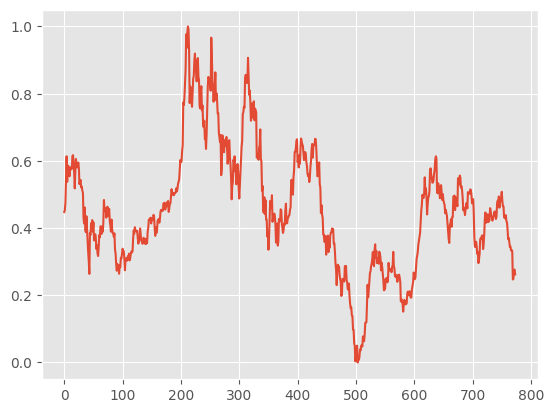

In [29]:
plt.plot(x,y)

窓スライド処理

In [30]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = [] # 4つ刻みのデータを格納する用のリスト
  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  #return seq_arr, target_arr
  return seq_arr.squeeze(), target_arr.squeeze()

In [31]:
y_seq, y_target = make_sequence_data(y , seq_length)

In [32]:
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [33]:
y_seq_train.shape

(767, 5)

pytorch用の処理

In [34]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [35]:
y_target_t.shape
#y_seq_t.shape

torch.Size([767])

LSTMの定義
 #x_last=x[-1]は予測したラストを抽出

In [36]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1]
    x = self.linear(x_last)
    return x

In [37]:
model = LSTM(hidden_size)

Loss関数と最適化アルゴの定義

In [38]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

LSTMに入力するための処理

In [39]:
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [40]:
y_seq_t = y_seq_t.permute(1,0)

In [41]:
# 40×450の2次元テンサーなので、1次元にする必要がる
 # unsqueezeはsqueezeの反対なのでsqueezeは40x450x1を絞って40x450にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [42]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [43]:
y_seq_t.shape

torch.Size([5, 767, 1])

学習トレーニング
ミニバッチのランニングLossを初期化することが通常だが
今回はバッチ学習のためいきなりOptimizerの初期化を実施します

In [44]:

losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 0.2834228277206421
epoch: 10, loss: 0.03470255434513092
epoch: 20, loss: 0.02145836129784584
epoch: 30, loss: 0.023139113560318947
epoch: 40, loss: 0.018534371629357338


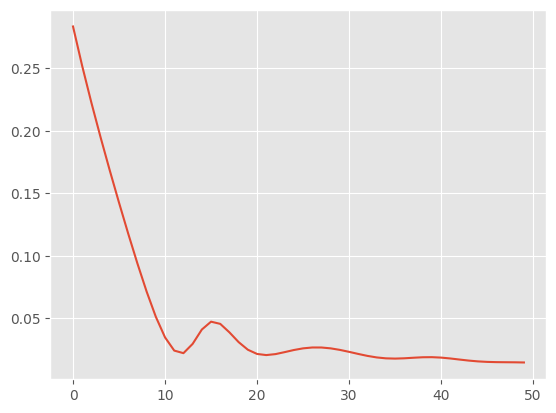

In [45]:
plt.plot(losses)

In [46]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [47]:
y_seq_test_t.size()

torch.Size([5, 2, 1])

In [48]:
#print(y_seq_test_t)

In [49]:
y_pred = model(y_seq_test_t)

(754.0, 776.0)

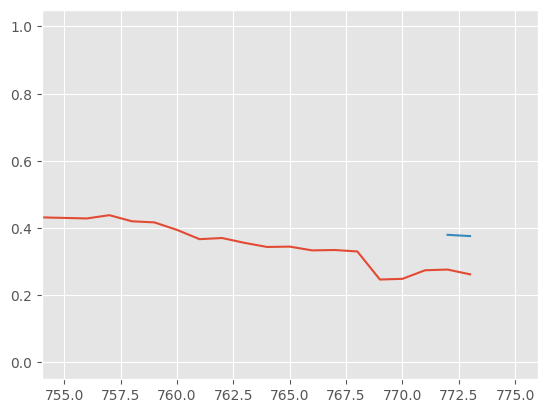

In [50]:
plt.plot(x,y)
plt.plot(np.arange(allsize-num_test,allsize),y_pred.detach())
plt.xlim([allsize-num_test*10,allsize+num_test])

予測

In [63]:
#seq_length=10
#num_test=10
print(f"最後尾のデータは{scaled_data[-1]}")
maxnum=len(scaled_data)
ii=0
jj=0
yy=[]
for ii in range(seq_length):
  #yy=[]
  for jj in range(num_test):
    yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
    yy.append(yy_value)
    #print(f"count:{ii+jj-seq_length-num_test+2} {yy}")
    jj+=1
#print(yy)

# yyをtorch.Tensorに変換
yy_tensor = torch.tensor(yy)
yy_tensor_reshaped = yy_tensor.view(seq_length,num_test)
yy_tensor_reshaped = yy_tensor_reshaped.unsqueeze(dim=-1)
print(yy_tensor_reshaped)
print(yy_tensor_reshaped.size())
# prediction
y_pred2 = model(yy_tensor_reshaped)
y_pred2[-1]


最後尾のデータは[0.26233145]
tensor([[[0.3304],
         [0.2469]],

        [[0.2469],
         [0.2489]],

        [[0.2489],
         [0.2744]],

        [[0.2744],
         [0.2766]],

        [[0.2766],
         [0.2623]]])
torch.Size([5, 2, 1])


<ipython-input-63-6293397d0bd3>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])


tensor([0.3731], grad_fn=<SelectBackward0>)

In [66]:
#seq_length=10
#num_test=10
# prediction loop
pred_days=2
#maxnum=len(scaled_data)
ii=0
jj=0
kk=0
#yy=[]
for kk in range(pred_days):
  yy=[]
  for ii in range(seq_length):
    for jj in range(num_test):
      yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
      yy.append(yy_value)
      #print(f"count:{ii+jj-seq_length-num_test+2} {yy}")
      jj+=1
  #print(yy)
  # yyをtorch.Tensorに変換
  yy_tensor = torch.tensor(yy)
  yy_tensor_reshaped = yy_tensor.view(seq_length,num_test)
  yy_tensor_reshaped = yy_tensor_reshaped.unsqueeze(dim=-1)
  print(yy_tensor_reshaped)
  print(yy_tensor_reshaped.size())
  # prediction
  y_pred2 = model(yy_tensor_reshaped)
  #y_pred2[-1]
  # y_pred2[-1]をscaled_dataの末尾に付与
  scaled_data_tensor = torch.tensor(scaled_data)
  scaled_data = torch.cat((scaled_data_tensor, y_pred2[-1].unsqueeze(0)), dim=0)
  # 結果を表示
print(scaled_data[-1])


tensor([[[0.2489],
         [0.2744]],

        [[0.2744],
         [0.2766]],

        [[0.2766],
         [0.2623]],

        [[0.2623],
         [0.3731]],

        [[0.3731],
         [0.3809]]])
torch.Size([5, 2, 1])
tensor([[[0.2744],
         [0.2766]],

        [[0.2766],
         [0.2623]],

        [[0.2623],
         [0.3731]],

        [[0.3731],
         [0.3809]],

        [[0.3809],
         [0.3910]]])
torch.Size([5, 2, 1])
tensor([0.4007], dtype=torch.float64, grad_fn=<SelectBackward0>)


<ipython-input-66-25ab418a453a>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_data_tensor = torch.tensor(scaled_data)
